# Jupyter Notebook Implementation of GANs for AI Fairness

**Model Class:**    Supervised</br>
**Model Type:**     Classification</br>

**Purpose**: This notebook provides a template for correcting biases through "fairer" training methods.  

This notebook can be used as is with little change to the training and evaluation code to build a fair implementation of GANs. 



**Edit Date** : 24/04/2019


- **Resources**
    * Learning to Pivot with Adversarial Networks: by Gilles Louppe

</br></br>

- **Data**</br>
    - The Fico Dataset with "Age", "Gender" and "Ethnicity" synthetically created skewed attributes.

- **Goal**</br>
    - Train an algorithm that takes fair Loan approval decisions based on age, gender, ethnicity.
    
# Dependencies

Load the dependencies for model development. Current package requirements include:
* Keras
* Pandas
* Numpy
* Sklearn
* Matplotlib

The current template uses the following versions:
* Keras version: 2.1.6
* Sklearn version: 0.20.2
* Pandas version: 0.24.2
* Numpy version: 1.16.2
* Matplotlib version: 2.2.2

In [28]:
#Loading libraries and other dependencies
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
create_gif = True

In [29]:
print(f"keras: {ke.__version__}")

keras: 2.1.6


# Load Data

### Read the data
* The first step is to import the dataset. Removing the "Age" attribute and "Unnamed: 0", which will not be used as a part of our analysis.  


In [30]:
#Removing unused fields in the dataset.
input_data = pd.read_csv("Biased_data.csv")
del input_data['Unnamed: 0']
del input_data["Age"]

In [31]:
input_data

RiskPerformance  ExternalRiskEstimate  MSinceOldestTradeOpen  \
0                   0                    71                    144   
1                   0                    43                     58   
2                   0                    34                     66   
3                   0                    49                    169   
4                   0                    80                    333   
5                   1                    83                    137   
6                   1                    94                     88   
7                   0                    73                    148   
8                   0                    80                    324   
9                   1                    22                     79   
10                  1                    30                     96   
11                  1                    97                    311   
12                  0                    41                    274   
13                  1                    90                    256   
14                  0                    44                    262   
15                  0                    20                    184   
16                  1                    78                    256   
17                  0                    83                    131   
18                  0                    94                    244   
19                  1                    88                     43   
20                  0                    34                    147   
21                  0                    89                    365   
22                  0                    83                     84   
23                  1                    90                     88   
24                  0                    47                     91   
25                  1                    26                    265   
26                  0                    23                    150   
27                  0                    89                    162   
28                  1                    70                    284   
29                  1                    80                    476   
...               ...                   ...                    ...   
9830                0                    92                    132   
9831                1                    84                     69   
9832                0                    33                    168   
9833                1                    82                    258   
9834                1                    95                    272   
9835                1                    89                    202   
9836                1                    25                    434   
9837                0                    22                    127   
9838                1                    99                    115   
9839                1                    98                    120   
9840                0                    91                    224   
9841                1                    22                    162   
9842                1                    30                    155   
9843                1                    75                    424   
9844                0                    46                    353   
9845                0                    40                     82   
9846                1                    75                    264   
9847                0                    73                    171   
9848                0                    93                    417   
9849                0                    72                     95   
9850                1                    81                    176   
9851                0                    48                    313   
9852                1                    57                    133   
9853                1                    29                    197   
9854                1                    76                    410   
9855            

# Process the data

### Specify Sensitive Attributes
* The variables that will not be used by the model but are being dicriminated on by the model
* Specify the variables and privileged group for each variable.
* Specify the 'target variable' as y
* Specify the 'legit model variables' as x

In [32]:
sensitive_attribs = ['Gender', 'Ethnicity']
#sensitive_attribs_privileged = ['Male', 'White']
Z = (input_data.loc[:, sensitive_attribs]
         .assign(Gender=lambda df: (df[sensitive_attribs[0]] == "Male").astype(int),
                 Ethnicity=lambda df: (df[sensitive_attribs[1]] == "White").astype(int)))


In [33]:
y = (input_data['RiskPerformance'] == 1).astype(int)

In [34]:
X = (input_data
     .drop(columns=['RiskPerformance', 'Gender', 'Ethnicity'])
     .fillna('Unknown')
     .pipe(pd.get_dummies, drop_first=True))

In [35]:
print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
print(f"targets y: {y.shape[0]} samples")
print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")

features X: 9860 samples, 21 attributes
targets y: 9860 samples
sensitives Z: 9860 samples, 2 attributes


In [36]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.5, 
                                                                     stratify=y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler)

/Users/asingh384/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/asingh384/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/Users/asingh384/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


# Train a simple classifier neural network

### Specify the Hyperparameters and Network Structure
* The neural network is a simple classifier trained to classify "Good Risk" vs "Bad Risk"

In [37]:
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    outputs = Dense(1, activation='sigmoid')(dropout3)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# initialise NeuralNet Classifier
clf = nn_classifier(n_features=X_train.shape[1])

# train on train set
history = clf.fit(X_train.values, y_train.values, epochs=20, verbose=0)

In [38]:
# predict on test set
y_pred = pd.Series(clf.predict(X_test).ravel(), index=y_test.index)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Accuracy: {100*accuracy_score(y_test, (y_pred>0.5)):.1f}%")


ROC AUC: 0.85
Accuracy: 78.8%


In [39]:
input_data

RiskPerformance  ExternalRiskEstimate  MSinceOldestTradeOpen  \
0                   0                    71                    144   
1                   0                    43                     58   
2                   0                    34                     66   
3                   0                    49                    169   
4                   0                    80                    333   
5                   1                    83                    137   
6                   1                    94                     88   
7                   0                    73                    148   
8                   0                    80                    324   
9                   1                    22                     79   
10                  1                    30                     96   
11                  1                    97                    311   
12                  0                    41                    274   
13                  1                    90                    256   
14                  0                    44                    262   
15                  0                    20                    184   
16                  1                    78                    256   
17                  0                    83                    131   
18                  0                    94                    244   
19                  1                    88                     43   
20                  0                    34                    147   
21                  0                    89                    365   
22                  0                    83                     84   
23                  1                    90                     88   
24                  0                    47                     91   
25                  1                    26                    265   
26                  0                    23                    150   
27                  0                    89                    162   
28                  1                    70                    284   
29                  1                    80                    476   
...               ...                   ...                    ...   
9830                0                    92                    132   
9831                1                    84                     69   
9832                0                    33                    168   
9833                1                    82                    258   
9834                1                    95                    272   
9835                1                    89                    202   
9836                1                    25                    434   
9837                0                    22                    127   
9838                1                    99                    115   
9839                1                    98                    120   
9840                0                    91                    224   
9841                1                    22                    162   
9842                1                    30                    155   
9843                1                    75                    424   
9844                0                    46                    353   
9845                0                    40                     82   
9846                1                    75                    264   
9847                0                    73                    171   
9848                0                    93                    417   
9849                0                    72                     95   
9850                1                    81                    176   
9851                0                    48                    313   
9852                1                    57                    133   
9853                1                    29                    197   
9854                1                    76                    410   
9855            

In [40]:
def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    legend={'Ethnicity': ['black','white'],
            'Gender': ['female','male']}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0, 1]:
            ax = sns.distplot(y[Z[attr] == attr_val], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format(legend[attr][attr_val]), 
                              ax=axes[idx])
        ax.set_xlim(0,1)
        ax.set_ylim(0,7)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx == 0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{RiskPerformance=1}}|z_{{{}}})$'.format(attr))
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     [f"- {attr}: {p_rules[attr]:.0f}%-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    return fig

/Users/asingh384/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


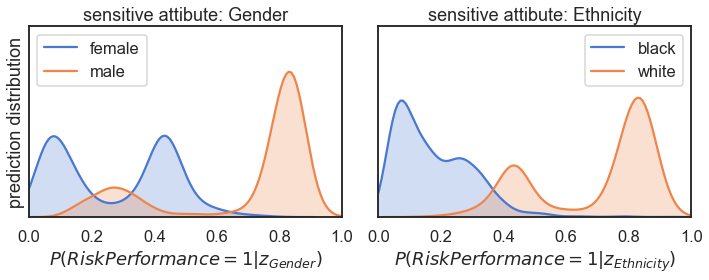

In [41]:
fig = plot_distributions(y_pred, Z_test)

# Define a "Fairness Measure"

### Specify a fairness measure to define fairness

* The rule is based on an acceptance rates for males and females, blacks and whites. A complete 100% p-rule implies complete independence from age/gender. The target variable is completely independent of age, gender etc.

In [42]:
# HIDE
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [43]:
print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['Gender']):.0f}%-rule")
print(f"\tgiven attribute race; {p_rule(y_pred, Z_test['Ethnicity']):.0f}%-rule")

The classifier satisfies the following %p-rules:
	given attribute sex;  9%-rule
	given attribute race; 2%-rule


In [44]:
# HIDE
def acceptance_rates(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    disparity = (y_z_1.mean(), y_z_0.mean())
    return disparity

In [45]:
print("The classifier satisfies the following %acceptance-rates:")
print("The acceptance rate for males is {}% and females is {}%".format(acceptance_rates(y_pred, Z_test['Gender'])[0]*100,
                                                                  acceptance_rates(y_pred, Z_test['Gender'])[1]*100))
print("The acceptance rate for whites is {}% and blacks is {}%".format(acceptance_rates(y_pred, Z_test['Ethnicity'])[0]*100,
                                                                  acceptance_rates(y_pred, Z_test['Ethnicity'])[1]*100))

The classifier satisfies the following %acceptance-rates:
The acceptance rate for males is 76.67009249743063% and females is 7.011437095972154%
The acceptance rate for whites is 71.99633139712626% and blacks is 1.4466546112115732%


# Defining a Neural Network (GANs) for Fair Classification

### Create adversial network
* Training the algorithm to weaken the correlation between gender, ethnicity etc. and target variable ("RiskPerformance").



In [46]:

class FairClassifier(object):
    
    def __init__(self, n_features, n_sensitive, lambdas):
        self.lambdas = lambdas
        
        clf_inputs = Input(shape=(n_features,))
        adv_inputs = Input(shape=(1,))
        
        clf_net = self._create_clf_net(clf_inputs)
        adv_net = self._create_adv_net(adv_inputs, n_sensitive)
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)
        self._clf = self._compile_clf(clf_net)
        self._clf_w_adv = self._compile_clf_w_adv(clf_inputs, clf_net, adv_net)
        self._adv = self._compile_adv(clf_inputs, clf_net, adv_net, n_sensitive)
        self._val_metrics = None
        self._fairness_metrics = None
#        self._fairness_metrics_1 = None
        
        self.predict = self._clf.predict
        
    def _make_trainable(self, net):
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable
        
    def _create_clf_net(self, inputs):
        dense1 = Dense(32, activation='relu')(inputs)
        dropout1 = Dropout(0.2)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        dense3 = Dense(32, activation='relu')(dropout2)
        dropout3 = Dropout(0.2)(dense3)
        outputs = Dense(1, activation='sigmoid', name='y')(dropout3)
        return Model(inputs=[inputs], outputs=[outputs])
        
    def _create_adv_net(self, inputs, n_sensitive):
        dense1 = Dense(32, activation='relu')(inputs)
        dense2 = Dense(32, activation='relu')(dense1)
        dense3 = Dense(32, activation='relu')(dense2)
        outputs = [Dense(1, activation='sigmoid')(dense3) for _ in range(n_sensitive)]
        return Model(inputs=[inputs], outputs=outputs)

    def _compile_clf(self, clf_net):
        clf = clf_net
        self._trainable_clf_net(True)
        clf.compile(loss='binary_crossentropy', optimizer='adam')
        return clf
        
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):
        clf_w_adv = Model(inputs=[inputs], outputs=[clf_net(inputs)]+adv_net(clf_net(inputs)))
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        loss_weights = [1.]+[-lambda_param for lambda_param in self.lambdas]
        clf_w_adv.compile(loss=['binary_crossentropy']*(len(loss_weights)), 
                          loss_weights=loss_weights,
                          optimizer='adam')
        return clf_w_adv

    def _compile_adv(self, inputs, clf_net, adv_net, n_sensitive):
        adv = Model(inputs=[inputs], outputs=adv_net(clf_net(inputs)))
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        adv.compile(loss=['binary_crossentropy']*n_sensitive, optimizer='adam')
        return adv

    def _compute_class_weights(self, data_set):
        class_values = [0, 1]
        class_weights = []
        if len(data_set.shape) == 1:
            balanced_weights = compute_class_weight('balanced', class_values, data_set)
            class_weights.append(dict(zip(class_values, balanced_weights)))
        else:
            n_attr =  data_set.shape[1]
            for attr_idx in range(n_attr):
                balanced_weights = compute_class_weight('balanced', class_values,
                                                        np.array(data_set)[:,attr_idx])
                class_weights.append(dict(zip(class_values, balanced_weights)))
        return class_weights
    
    def _compute_target_class_weights(self, y):
        class_values  = [0,1]
        balanced_weights =  compute_class_weight('balanced', class_values, y)
        class_weights = {'y': dict(zip(class_values, balanced_weights))}
        return class_weights
        
    def pretrain(self, x, y, z, epochs=10, verbose=0):
        self._trainable_clf_net(True)
        self._clf.fit(x.values, y.values, epochs=epochs, verbose=verbose)
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        class_weight_adv = self._compute_class_weights(z)
        self._adv.fit(x.values, np.hsplit(z.values, z.shape[1]), class_weight=class_weight_adv, 
                      epochs=epochs, verbose=verbose)
        
    def fit(self, x, y, z, validation_data=None, T_iter=250, batch_size=128,
            save_figs=False):
        n_sensitive = z.shape[1]
        if validation_data is not None:
            x_val, y_val, z_val = validation_data

        class_weight_adv = self._compute_class_weights(z)
        class_weight_clf_w_adv = [{0:1., 1:1.}]+class_weight_adv
        self._val_metrics = pd.DataFrame()
        self._fairness_metrics = pd.DataFrame()  
        self._fairness_metrics_1 = pd.DataFrame()  
        for idx in range(T_iter):
            if validation_data is not None:
                y_pred = pd.Series(self._clf.predict(x_val).ravel(), index=y_val.index)
                self._val_metrics.loc[idx, 'ROC AUC'] = roc_auc_score(y_val, y_pred)
                self._val_metrics.loc[idx, 'Accuracy'] = (accuracy_score(y_val, (y_pred>0.5))*100)
                for sensitive_attr in z_val.columns:
                    
                    self._fairness_metrics.loc[idx, sensitive_attr] = p_rule(y_pred,
                                                                             z_val[sensitive_attr])
#                     self._fairness_metrics_1.loc[idx, sensitive_attr] = acceptance_rates(y_pred,
#                                                                              z_val[sensitive_attr])[0]
                    
                    
                display.clear_output(wait=True)
                plot_distributions(y_pred, z_val, idx+1, self._val_metrics.loc[idx],
                                   self._fairness_metrics.loc[idx],
#                                   self._fairness_metrics_1.loc[idx],
                                   fname=f'{idx+1:08d}.png' if save_figs else None)
                plt.show(plt.gcf())
            
            # train adverserial
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            self._adv.fit(x.values, np.hsplit(z.values, z.shape[1]), batch_size=batch_size, 
                          class_weight=class_weight_adv, epochs=1, verbose=0)
            
            # train classifier
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            indices = np.random.permutation(len(x))[:batch_size]
            self._clf_w_adv.train_on_batch(x.values[indices], 
                                           [y.values[indices]]+np.hsplit(z.values[indices], n_sensitive),
                                           class_weight=class_weight_clf_w_adv)

In [47]:
# initialise FairClassifier
clf = FairClassifier(n_features=X_train.shape[1], n_sensitive=Z_train.shape[1],
                     lambdas=[40., 5.])

# pre-train both adverserial and classifier networks
clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5)

In [48]:
# HIDE
if create_gif:
    !rm /*.png

rm: /*.png: No such file or directory


/Users/asingh384/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


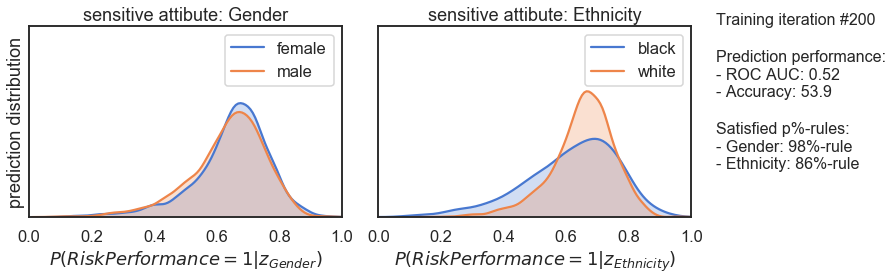

In [49]:
# adverserial train on train set and validate on test set
clf.fit(X_train, y_train, Z_train, 
        validation_data=(X_test, y_test, Z_test),
        T_iter=200, save_figs=True)
